In [1]:
import xarray as xr

from pydantic import BaseModel, constr, field_validator, ValidationInfo, model_validator
from datetime import datetime
from typing import List, Any, Optional
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
class HydCal(BaseModel):
    refdes: constr(min_length=27, max_length=27)
    deployment: str
    asset_id: constr(min_length=17, max_length=17)
    model: str
    sn: int
    cal_date: datetime
    frequencies: List[float]
    sens: List[float] = None
    sens0: List[float] = None
    sens90: List[float] = None
    ds: Any = None
    rca_bb_offset: float = 128.9

    @model_validator(mode="after")
    def convert_date(self):
        """Convert cal_date to an ISO 8601 string immediately after instantiation."""
        self.cal_date = self.cal_date.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
        return self  # Must return self in a model validator

    @field_validator("frequencies", mode="before")
    @classmethod
    def convert_freqs(cls, values):
        """Convert kHz to Hz by multiplying each element by 1000."""
        return [v * 1000 for v in values]

    @field_validator("sens")
    @classmethod
    def check_lengths(cls, v, info):
        if "frequencies" in info.data and len(v) != len(info.data["frequencies"]):
            raise ValueError("sens and frequencies must be the same length")
        return v

    def make_ndarray(self):
        if self.sens is not None:
            print("creating only a single sensitivity data var")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity": (["frequency"], self.sens),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "asset_id": self.asset_id,
                "model": self.model,
                "serial_number": self.sn,
                "calibration_date": self.cal_date,
            }
            )
        elif self.sens0 is not None and self.sens90 is not None:
            print("creating both 0 and 90 degree sensitivities")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity_0": (["frequency"], self.sens0),
                "sensitivity_90": (["frequency"], self.sens90),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "asset_id": self.asset_id,
                "model": self.model,
                "serial_number": self.sn,
                "calibration_date": self.cal_date,
            }
            )
            

    def save_cal(self):
        self.ds.to_netcdf(f"../metadata/cals/{refdes}_{deployment}.nc", mode="w")

    def save_correction_cal(self):
        if self.sens is not None:
            self.ds["sensitivity"] = self.ds["sensitivity"] + self.rca_bb_offset 
        elif self.sens0 is not None and self.sens90 is not None:
            self.ds["sensitivity"] = (self.ds["sensitivity_0"] + self.ds["sensitivity_90"]) / 2
            self.ds["sensitivity"] = self.ds["sensitivity"] + self.rca_bb_offset 

        self.ds.to_netcdf(f"../metadata/rca_correction_cals/{refdes}_{deployment}.nc", mode="w")
        
        

In [3]:
refdes = "RS01SLBS-LJ01A-09-HYDBBA102"
deployment = "2"

In [4]:
asset_id = "ATAPL-58324-00010"  #
model = "SB2-ETH"  #
sn = 1363  #
cal_date = datetime(2015, 5, 13)  #

frequency = [
    0.0,
    10.0,
    20.1,
    30.1,
    40.2,
    50.2,
    60.2,
    70.3,
    80.3,
    90.4,
    100.4,
    110.4,
    120.5,
    130.5,
    140.5,
    150.6,
    160.6,
    170.7,
    180.7,
    190.7,
    200.0
]

sens0 = [
    -169.6,
    -169.6,
    -171.8,
    -171.5,
    -171.2,
    -172.8,
    -171.6,
    -173.0,
    -173.8,
    -175.7,
    -175.1,
    -175.3,
    -175.2,
    -173.8,
    -171.9,
    -171.5,
    -167.0,
    -165.7,
    -168.5,
    -172.7,
    -174.9
]

sens90 = [
    -170.2,
    -170.2,
    -171.7,
    -171.7,
    -171.2,
    -172.5,
    -171.7,
    -172.1,
    -173.3,
    -174.9,
    -174.9,
    -177.6,
    -176.4,
    -174.3,
    -171.0,
    -169.8,
    -166.7,
    -166.2,
    -169.0,
    -172.2,
    -174.1
]

In [5]:
hyd = HydCal(
    refdes=refdes,
    deployment=deployment,
    asset_id=asset_id,
    model=model,
    sn=sn,
    cal_date=cal_date,
    frequencies = frequency,
    #sens=sens,
    sens0=sens0,
    sens90=sens90,
    )

hyd.make_ndarray()

creating both 0 and 90 degree sensitivities


In [6]:
hyd.cal_date

'2015-05-13T00:00:00.000000Z'

In [7]:
hyd.ds.sensitivity.plot()  # Plot the DataArray

AttributeError: 'Dataset' object has no attribute 'sensitivity'

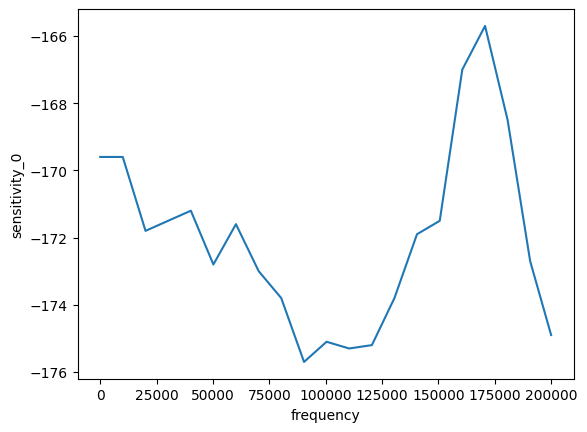

In [8]:
hyd.ds["sensitivity_0"].plot()  # Plot the DataArray

In [9]:
hyd.save_cal()
hyd.save_correction_cal()

In [12]:
test = xr.open_dataset(f"../metadata/rca_correction_cals/{refdes}_{deployment}.nc")

In [13]:
test.sensitivity.values

array([-41.  , -41.  , -42.85, -42.7 , -42.3 , -43.75, -42.75, -43.65,
       -44.65, -46.4 , -46.1 , -47.55, -46.9 , -45.15, -42.55, -41.75,
       -37.95, -37.05, -39.85, -43.55, -45.6 ])

In [13]:
test

<xarray.Dataset>
Dimensions:      (frequency: 20)
Coordinates:
  * frequency    (frequency) float64 0.0 1e+04 2.01e+04 ... 1.807e+05 1.907e+05
Data variables:
    sensitivity  (frequency) float64 -39.5 -39.5 -39.2 ... -37.6 -41.1 -43.8
Attributes:
    asset_id:          ATAPL-58324-00006
    model:             SB35-ETH
    serial_number:     1291
    calibration_date:  2014-05-20T00:00:00.000000Z

In [13]:
#product_viz = xr.open_dataset("/Users/joeduprey/repos/ooi-hyd-tools/output/HYDBBA106_20170401.nc")

In [14]:
#product_viz.sensitivity.values

In [10]:
dep4 = xr.open_dataset(f"../metadata/rca_correction_cals/RS03AXBS-LJ03A-09-HYDBBA302_4.nc")

In [16]:
dep4

<xarray.Dataset>
Dimensions:         (frequency: 21)
Coordinates:
  * frequency       (frequency) float64 0.0 1e+04 2.01e+04 ... 1.907e+05 2e+05
Data variables:
    sensitivity_0   (frequency) float64 ...
    sensitivity_90  (frequency) float64 ...
    sensitivity     (frequency) float64 ...

In [17]:
dep4.sensitivity.values

array([-40.85, -40.85, -41.65, -42.05, -41.6 , -44.7 , -43.95, -45.7 ,
       -46.05, -47.4 , -47.1 , -48.6 , -47.75, -46.2 , -44.2 , -41.6 ,
       -38.9 , -38.05, -40.9 , -44.2 , -46.5 ])

In [18]:
dep5 = xr.open_dataset(f"../metadata/rca_correction_cals/RS03AXBS-LJ03A-09-HYDBBA302_5.nc")

In [19]:
dep5.sensitivity.values

array([-39.75, -39.75, -42.  , -41.85, -42.3 , -41.95, -41.65, -40.45,
       -41.8 , -42.8 , -43.9 , -44.55, -42.65, -40.75, -39.5 , -39.15,
       -37.2 , -37.1 , -37.3 , -40.05, -43.35])